In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse, linalg

# Уравнение теплопроводности

Начально-краевая задача для уравнения теплопроводности с постоянным коэффициентом в общем виде можно записать следующим образом:
$$
\begin{array}{l}
\dfrac{\partial u}{\partial t} = \alpha \dfrac{\partial^2 u}{\partial x^2} + f(x, t), \; t > 0, \; x \in (0, l_x), \\
\left. u \right|_{t=0} = u_0(x), \\
\left. u \right|_{x=0} = \mu_1(t), \\
\left. u \right|_{x=l_x} = \mu_2(t),
\end{array}$$
где $u(x, t)$ - функция температуры, $\alpha = const$ - коэффициент теплопроводности, $f(x, t)$ - функция источника. 

## Явная схема

Запишем разностное уравнение явной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k} - 2 y_i^{k} + y_{i-1}^{k}}{h^2} + f_i^k,$$
где $\tau$ и $h$ - шаги по времени и пространству, $y_i^k$ - значение приближённого решения в точке $(i, k)$ сетки, $y_i^k$ - значение функции источника в той же точке сетки. 

Аппроксимируем начальное и граничные условия:
$$
\begin{array}{l}
y_i^0 = u_0(x_i), \; \forall i = \overline{0, N},\\
y_0^k = \mu_1(t_k), \\
y_N^k = \mu_2(t_k), \; \forall k > 0.
\end{array}$$

Запрограммируйте явную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности. Обратите внимание, что 
$$\exists \lim\limits_{t \rightarrow \infty} u(x, t) = u_\infty (x).$$
поэтому расчёт в какой-то момент следует остановить (считать до установления).

Во время проведения расчетов помните о том, что явная схема *условно* устойчива.

In [3]:
def heat_expl(init, bound1, bound2, alpha, lx, h, tau, tol=1e-3):
    """ Solve the heat equation `u_t = a*u_xx` for x in (0; lx) with an explicit scheme.
    
    Parameters
    ----------
    init : callable
       Initial condition
    bound1 : callable
       Boundary condition for x = 0
    bound1 : callable
       Boundary condition for x = lx
    alpha : float
       Thermal diffusivity
    h : float
       Spatial step
    tau : float
       Time step
    tol : float, optional
       Target tolerance.
       Stop iterations when the 2-norm of the difference between 
       solution on this time step and the next is less the tol.
       
    Returns
    -------
    t_end : ndarray, shape (n,)
       End time of calculation
    u_end : ndarray, shape (N,)
       Limit u_∞(x) (See above)
    """
    N = round(lx/h) + 1
    u = np.array(list(map(init, np.linspace(0, lx, num=N))))
    u_end = np.empty_like(u)
    t_end = tau
    n = 0
    while n < 1000:
      u_end[1:-1] = u[1:-1] + tau * alpha * (u[2:] - 2 * u[1:-1] + u[:-2]) / (h * h)
      u_end[0] = bound1(t_end)
      u_end[-1] = bound2(t_end)
      
      if np.linalg.norm(u_end - u) < tol:
        return t_end, u_end
      u = u_end.copy()
      t_end += tau
      n += 1
    return t_end, u_end

Протестируйте Вашу функцию.

In [4]:
from numpy.testing import assert_allclose

t_0, u_0 = heat_expl(lambda x: 0., lambda x: 1., lambda x: 1., 
                     alpha=1., lx=1., h=0.1, tau=0.005) 
assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_expl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                     alpha=1., lx=np.pi, h=0.1, tau=0.005) 
assert_allclose(u_1, np.zeros(32), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче. Для этого для каждой переменной ($t$ или $x$):

1. Сделайте несколько расчётов для разных значений шага (например, $h_0, \; 2 h_0, \; 4 h_0$).
2. В один и тот же момент времени $t_1$ найдите ошибку полученных решений. Для этого либо возьмите аналитическое решение задачи, либо сравните результат в конечный момент времени, например, с решением в момент времени $0.99 t_1$. Обратите внимание, что имеющуюся функцию `heat_expl` надо немного модифицировать.
3. Найдите отношения этих ошибок. Сопоставьте полученные величины с порядком аппроксимации схемы по данной переменной.

In [5]:
u = lambda x, t: np.exp(-9*t)*np.sin(3*x)
lx = np.pi
t1 = 0.5

f = lambda i: np.abs(computed_us[i] - real_us[i])

In [6]:
def heat_expl_modified(t1, init, bound1, bound2, alpha, lx, h, tau, tol=1e-3):
    N = round(lx/h) + 1
    u = np.array(list(map(init, np.linspace(0, lx, num=N))))
    u_end = np.empty_like(u)
    t_end = tau
    while True:
      u_end[1:-1] = u[1:-1] + tau * alpha * (u[2:] - 2 * u[1:-1] + u[:-2]) / (h * h)
      u_end[0] = bound1(t_end)
      u_end[-1] = bound2(t_end)
      
      if t_end >= t1:
        return u_end
      u = u_end.copy()
      t_end += tau

### h (без смены tau)

In [7]:
hs = []
ts = []
N = 5
tau = 0.01
while tau / (lx/(N-1))**2 < 1/2:
  t_0, u_0 = heat_expl(lambda x: u(x, 0),
                       lambda x: u(0, x),
                       lambda x: u(lx, x),
                       alpha=1,
                       lx=lx,
                       h=lx/(N-1),
                       tau=tau)
  if np.allclose(u_0, np.zeros(N), atol=1e-2):
    hs.append(lx/(N-1))
    ts.append(t_0)
  N += 1

In [8]:
computed_us = []
real_us = []
for h in hs:
  u_end = heat_expl_modified(t1,
                             lambda x: u(x, 0),
                             lambda x: u(0, x),
                             lambda x: u(lx, x),
                             alpha=1,
                             lx=lx,
                             h=h,
                             tau=tau)
  computed_us.append(u_end)
  real_us.append(u(np.linspace(0, lx, num=round(lx/h)+1), t1))

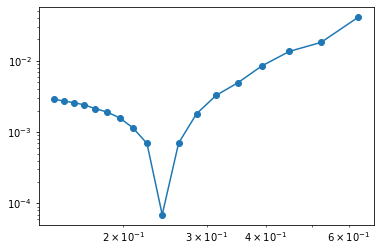

In [9]:
error = [hs[i] * (np.sum(f(i)[1:-1]) + (f(i)[0] + f(i)[-1]) / 2) for i in range(len(hs))]

plt.plot(hs, error, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.show()

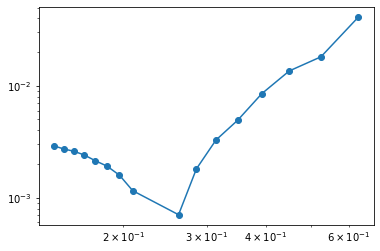

In [10]:
hs = hs[:8]+hs[-8:]
computed_us = computed_us[:8]+computed_us[-8:]
real_us = real_us[:8]+real_us[-8:]

error = [hs[i] * (np.sum(f(i)[1:-1]) + (f(i)[0] + f(i)[-1]) / 2) for i in range(len(hs))]

plt.plot(hs, error, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.show()


### tau (без смены h)

In [11]:
taus = []
ts = []
N = 15
h = np.pi/(N-1)
tau = 0.005
while tau / h**2 < 1/2:
  t_0, u_0 = heat_expl(lambda x: u(x, 0),
                       lambda t: 0,
                       lambda t: 0,
                       alpha=1,
                       lx=lx,
                       h=h,
                       tau=tau)
  if np.allclose(u_0, np.zeros(N), atol=1e-2):
    taus.append(tau)
    ts.append(t_0)
  tau += 0.001

In [12]:
computed_us = []
real_us = []
for tau in taus:
  u_end = heat_expl_modified(t1,
                             lambda x: u(x, 0),
                             lambda t: 0,
                             lambda t: 0,
                             alpha=1,
                             lx=lx,
                             h=h,
                             tau=tau)
  computed_us.append(u_end)
  real_us.append(u(np.linspace(0, lx, num=round(lx/h)+1), t1))

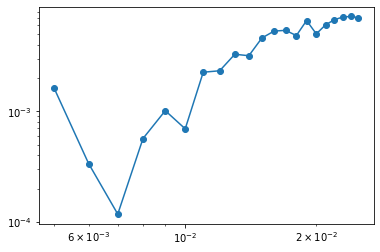

In [13]:
error = [h * (np.sum(f(i)[1:-1]) + (f(i)[0] + f(i)[-1]) / 2) for i in range(len(taus))]

plt.plot(taus, error, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.show()

### h

In [14]:
hs = []
ts = []
taus = []
for N in range(5, 30):
  tau = (lx/(N-1))**2 / 5
  t_0, u_0 = heat_expl(lambda x: u(x, 0),
                       lambda t: 0,
                       lambda t: 0,
                       alpha=1,
                       lx=lx,
                       h=lx/(N-1),
                       tau=tau)
  if np.allclose(u_0, np.zeros(N), atol=1e-2):
    hs.append(lx/(N-1))
    ts.append(t_0)
    taus.append(tau)

In [15]:
computed_us = []
real_us = []
for (h, tau) in zip(hs, taus):
  u_end = heat_expl_modified(t1,
                             lambda x: u(x, 0),
                             lambda t: 0,
                             lambda t: 0,
                             alpha=1,
                             lx=lx,
                             h=h,
                             tau=tau)
  computed_us.append(u_end)
  real_us.append(u(np.linspace(0, lx, num=round(lx/h)+1), t1))

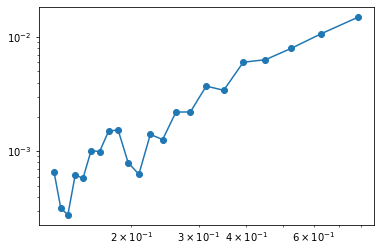

In [16]:
error = [hs[i] * (np.sum(f(i)[1:-1]) + (f(i)[0] + f(i)[-1]) / 2) for i in range(len(hs))]

plt.plot(hs, error, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.show()


### tau

In [50]:
hs = []
ts = []
taus = np.linspace(0.0075, 0.025)
for tau in taus:
  N = 3
  while tau/(lx/(N-1))**2 < 1/3:
    N += 1
  assert tau/(lx/(N-1))**2 < 1/2

  t_0, u_0 = heat_expl(lambda x: u(x, 0),
                       lambda t: 0,
                       lambda t: 0,
                       alpha=1,
                       lx=lx,
                       h=lx/(N-1),
                       tau=tau)
  if np.allclose(u_0, np.zeros(N), atol=1e-2):
    hs.append(lx/(N-1))
    ts.append(t_0)

In [51]:
print(len(taus), len(hs))

50 50


In [52]:
computed_us = []
real_us = []
for (h, tau) in zip(hs, taus):
  u_end = heat_expl_modified(t1,
                             lambda x: u(x, 0),
                             lambda t: 0,
                             lambda t: 0,
                             alpha=1,
                             lx=lx,
                             h=h,
                             tau=tau)
  computed_us.append(u_end)
  real_us.append(u(np.linspace(0, lx, num=round(lx/h)+1), t1))

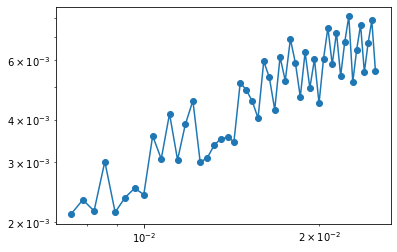

In [53]:
error = [hs[i] * (np.sum(f(i)[1:-1]) + (f(i)[0] + f(i)[-1]) / 2) for i in range(len(taus))]

plt.plot(taus, error, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Неявная схема 

Запишем разностное уравнение неявной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k+1} - 2 y_i^{k+1} + y_{i-1}^{k+1}}{h^2} + f_i^{k+1}.$$

Аппроксимировать начальное и граничные условия будем так же, как в случае явной схемы.

Запрограммируйте явную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности. Для решения системы линейных уравнений используйте встроенные функции `scipy`.

In [21]:
def heat_impl(init, bound1, bound2, alpha, lx, h, tau, tol=1e-3):
    """ Solve heat equation u_t = a*u_xx for x in (0; lx) with implicit scheme
    
    Parameters
    ----------
    init : callable
       Initial condition
    bound1 : callable
       Boundary condition for x = 0
    bound1 : callable
       Boundary condition for x = lx
    alpha : float, optional
       Thermal diffusivity
    h : float
       Spatial step
    tau : float
       Time step
    tol : float, optional
       Target tolerance.
       Stop iterations when the 2-norm of the difference between 
       solution on this time step and the next is less the tol.
       
    Returns
    -------
    t_end : ndarray, shape (n,)
       End time of calculation
    u_end : ndarray, shape (N,)
       Limit u_∞(x) (See above)
    """
    N = round(lx/h) + 1
    u = np.array(list(map(init, np.linspace(0, lx, num=N))))
    u_end = np.empty_like(u)
    t_end = tau
    gamma = alpha * tau / h**2
    n = 0
    ab = np.zeros((3, N))
    ab[0, 2:] = ab[2, :-2] = -gamma
    ab[1] = 1
    ab[1, 1:-1] += 2*gamma
    while n < 1000:
      b = u.copy()
      b[0] = bound1(t_end)
      b[-1] = bound2(t_end)
      u_end = linalg.solve_banded((1, 1), ab, b)

      if np.linalg.norm(u_end - u) < tol:
        return t_end, u_end
      u = u_end.copy()
      t_end += tau
      n += 1
        
    return t_end, u_end

Протестируйте Вашу функцию.

In [22]:
from numpy.testing import assert_allclose

t_0, u_0 = heat_impl(lambda x: 0, lambda x: 1., lambda x: 1., 
                     alpha=1., lx=1., h=0.1, tau=0.005) 
assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_impl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0., 
                     alpha=1., lx=np.pi, h=0.1, tau=0.005) 
assert_allclose(u_1, np.zeros(32), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче. (см. выше)

In [23]:
def heat_impl_modified(t1, init, bound1, bound2, alpha, lx, h, tau, tol=1e-3):
    N = round(lx/h) + 1
    u = np.array(list(map(init, np.linspace(0, lx, num=N))))
    u_end = np.empty_like(u)
    t_end = tau
    gamma = alpha * tau / h**2
    n = 0
    ab = np.zeros((3, N))
    ab[0, 2:] = ab[2, :-2] = -gamma
    ab[1] = 1
    ab[1, 1:-1] += 2*gamma
    while True:
      b = u.copy()
      b[0] = bound1(t_end)
      b[-1] = bound2(t_end)
      u_end = linalg.solve_banded((1, 1), ab, b)

      if t_end >= t1:
        return u_end
      u = u_end.copy()
      t_end += tau

### h

In [24]:
hs = []
ts = []
for N in range(5, 100):
  t_0, u_0 = heat_impl(lambda x: u(x, 0),
                       lambda t: 0,
                       lambda t: 0,
                       alpha=1,
                       lx=lx,
                       h=lx/(N-1),
                       tau=0.004)
  if np.allclose(u_0, np.zeros(N), atol=1e-2):
    hs.append(lx/(N-1))
    ts.append(t_0)

In [25]:
computed_us = []
real_us = []
for h in hs:
  u_end = heat_impl_modified(t1,
                             lambda x: u(x, 0),
                             lambda t: 0,
                             lambda t: 0,
                             alpha=1,
                             lx=lx,
                             h=h,
                             tau=0.004)
  computed_us.append(u_end)
  real_us.append(u(np.linspace(0, lx, num=round(lx/h)+1), t1))

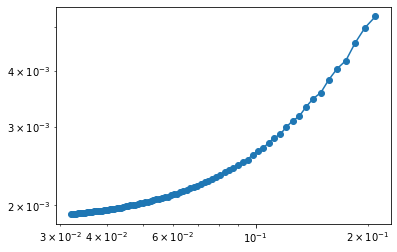

In [26]:
error = [hs[i] * (np.sum(f(i)[1:-1]) + (f(i)[0] + f(i)[-1]) / 2) for i in range(len(hs))]

plt.plot(hs, error, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.show()

### tau

In [27]:
taus = []
ts = []
N = 15
h = lx/(N-1)
tau = 0.005
for tau in np.linspace(0.0075, 0.1):
  t_0, u_0 = heat_impl(lambda x: u(x, 0),
                       lambda t: 0,
                       lambda t: 0,
                       alpha=1,
                       lx=lx,
                       h=h,
                       tau=tau)
  if np.allclose(u_0, np.zeros(N), atol=1e-2):
    taus.append(tau)
    ts.append(t_0)

In [28]:
computed_us = []
real_us = []
for tau in taus:
  u_end = heat_expl_modified(t1,
                             lambda x: u(x, 0),
                             lambda t: 0,
                             lambda t: 0,
                             alpha=1,
                             lx=lx,
                             h=h,
                             tau=tau)
  computed_us.append(u_end)
  real_us.append(u(np.linspace(0, lx, num=round(lx/h)+1), t1))

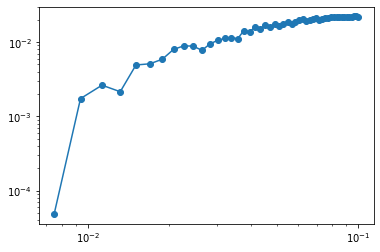

In [29]:
error = [h * (np.sum(f(i)[1:-1]) + (f(i)[0] + f(i)[-1]) / 2) for i in range(len(taus))]

plt.plot(taus, error, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.show()